This notebook is a demo of timbre transfer using DDSP (Differentiable Digital Signal Processing). 
The model here is trained to generate audio conditioned on a time series of fundamental frequency and loudness. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import gin
import time
import copy
import ddsp
import crepe
import pickle
import librosa
import ddsp.training

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from google.colab import files
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)

In [3]:
sample_rate = DEFAULT_SAMPLE_RATE

Starting recording for 5 seconds...


<IPython.core.display.Javascript object>

Finished recording!

Extracting audio features...


Audio features took 9.2 seconds


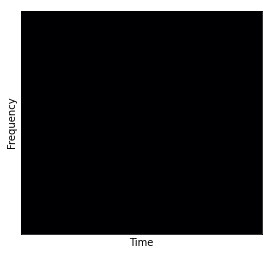

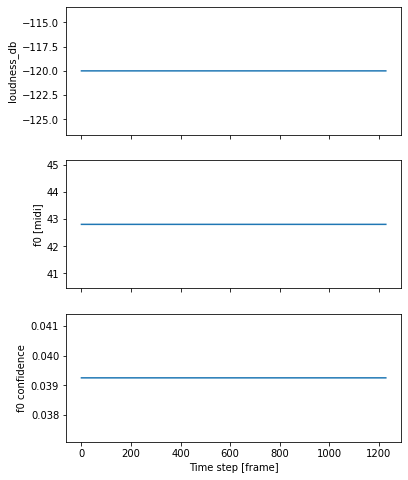

In [4]:
record_or_upload = "Record"  

record_seconds = 5

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
audio = audio[np.newaxis, :]

print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows = 3, 
                       ncols = 1, 
                       sharex = True,
                       figsize = (6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')